# Fixed-Horizon vs Mixture SPRT

This notebook compares three tests using Monte Carlo simulation:
1. Fixed-horizon test (oracle, designed for the true effect size)
2. Mixture SPRT with a low-variance prior around the true effect
3. Mixture SPRT with a high-variance prior around the true effect

Each test is evaluated **under the null (μ = 0)** and **under the alternative (μ > 0)**
to estimate Type I error, Type II error, and average duration.

In [42]:
import numpy as np
import pandas as pd

from scipy.stats import norm
import matplotlib.pyplot as plt

## 1. Data Generation and testing functions

In [43]:
def generate_period(mu, sigma, n):
    return np.random.normal(mu, sigma, size=n)

### Mixture SPRT Functions

In [44]:
def mixture_sprt_continuous(
    true_mu,
    prior_mean,
    prior_var
):
    """
    Continuous-mixture SPRT with Normal prior on mu.

    Returns:
        stopping_time : int
        decision : {1, 0, None}
        stopped : bool
    """

    A = (1 - beta) / alpha
    B = beta / (1 - alpha)
    logA, logB = np.log(A), np.log(B)

    log_lr = 0.0

    sum_x = 0.0
    sum_x2 = 0.0
    n_total = 0

    for t in range(1, max_periods + 1):
        x = generate_period(true_mu, sigma, n_per_period)

        n = len(x)
        sum_x += np.sum(x)
        sum_x2 += np.sum(x**2)
        n_total += n

        # H0: mu = 0
        ll0 = (
            -0.5 * n_total * np.log(2 * np.pi * sigma**2)
            -0.5 * sum_x2 / sigma**2
        )

        # H1: mu ~ N(prior_mean, prior_var)
        xbar = sum_x / n_total

        ll1 = (
            -0.5 * n_total * np.log(2 * np.pi * sigma**2)
            -0.5 * (sum_x2 - n_total * xbar**2) / sigma**2
            -0.5 * np.log(1 + n_total * prior_var / sigma**2)
            -0.5 * (xbar - prior_mean)**2 / (sigma**2 / n_total + prior_var)
        )

        log_lr = ll1 - ll0

        if log_lr >= logA:
            return t, 1, True

        if log_lr <= logB:
            return t, 0, True

    # No boundary crossed
    return max_periods, None, False



### Fixed-Horizon Test 
This is just a power calculation where we figure out errors with randomized data.

In [45]:
def fixed_horizon_test(true_mu):
    z_alpha = norm.ppf(1 - alpha)
    z_beta = norm.ppf(1 - beta)

    # Designed for the true effect size
    total_n = ((z_alpha + z_beta) * sigma / abs(true_mu)) ** 2

    total_n = int(np.ceil(total_n))

    periods = int(np.ceil(total_n / n_per_period))
    x = np.random.normal(true_mu, sigma, size=periods * n_per_period)

    z = x.mean() / (sigma / np.sqrt(len(x)))
    return periods, int(z >= z_alpha)

## 2. Monte Carlo Simulations

#### Main MC function

In [46]:
def run_simulations_continuous(n_sim, mu, prior_specs, prior_names):
    results = {'fixed': []}
    for prior_name in prior_names:
        results[prior_name] = []

    for _ in range(n_sim):
        if mu != 0:
            results['fixed'].append(fixed_horizon_test(mu))
        else:
            pass
        for i, (prior_mu, prior_var) in enumerate(prior_specs):
            results[prior_names[i]].append(
                mixture_sprt_continuous(mu, prior_mu, prior_var)
            )
        
    return results

#### Functions for gathering results

In [47]:
def summarize(results, is_null):
    times = np.array([r[0] for r in results])
    decisions = np.array([r[1] for r in results])

    summary = {
        'avg_duration': times.mean()
    }
    if is_null:
        summary['type_I_error'] = decisions.astype(float).mean()
    else:
        summary['type_II_error'] = 1 - decisions.astype(float).mean()

    return summary

In [48]:
def summarize_msprt(mc_results, key="msprt"):
    """
    Summarize Monte Carlo results for an mSPRT-style test.

    Args:
        mc_results : dict
            e.g. {"fixed": [...], "msprt": [...], "msprt_wide": [...]}
        key : str
            which entry corresponds to the mSPRT results

    Returns:
        dict with duration, power, stopping, and inconclusive rates
    """

    results = np.asarray(mc_results[key], dtype=object)

    t = results[:, 0].astype(float)
    decision = results[:, 1]
    stopped = results[:, 2].astype(bool)

    stopped_idx = stopped
    rejected = decision == 1

    n = len(results)

    return {
        "n_runs": n,

        # Sequential behavior
        "stopping_rate": stopped_idx.mean(),
        "percent_inconclusive": 1.0 - stopped_idx.mean(),

        # Conditional operating characteristics
        "power_given_stop": (
            rejected[stopped_idx].mean()
            if stopped_idx.any()
            else np.nan
        ),

        # Duration
        "mean_duration_given_stop": (
            t[stopped_idx].mean()
            if stopped_idx.any()
            else np.nan
        ),
        "mean_duration_overall": t.mean()
    }


In [49]:
def error_rates_msprt(mc_results, key, true_mu):
    """
    Compute Type I and Type II error rates for mSPRT-style results.

    Args:
        mc_results : dict
            Monte Carlo results dictionary
        key : str
            which test arm to analyze (e.g. "msprt")
        true_mu : float
            true effect size used in the simulation

    Returns:
        dict with FPR, FNR, and inconclusive rate
    """

    results = np.asarray(mc_results[key], dtype=object)

    decision = results[:, 1]
    stopped = results[:, 2].astype(bool)

    # Define ground truth
    is_null = np.isclose(true_mu, 0.0)
    is_alt = not is_null

    # Only stopped runs are eligible for error accounting
    stopped_idx = stopped

    if is_null:
        # False positives: reject H0 when H0 is true
        fpr = (decision[stopped_idx] == 1).mean() if stopped_idx.any() else np.nan
        fnr = np.nan
    else:
        # False negatives: accept H0 when H1 is true
        fpr = np.nan
        fnr = (decision[stopped_idx] == 0).mean() if stopped_idx.any() else np.nan

    return {
        "FPR": fpr,
        "FNR": fnr,
        "percent_inconclusive": 1.0 - stopped_idx.mean()
    }


### Functions for plotting results

In [50]:
## Here is a function for plotting the histogram and density plot
from scipy.stats import gaussian_kde

def plot_duration_densities(results
                            , title=None
                            , fixed_avg_duration=None
                            , bins=30, alpha=0.45):
    """
    results: dict produced by run_simulations (keys include 'fixed' and MSPRT variants)
    fixed_avg_duration: optional float to draw a vertical line (if None and 'fixed' in results, uses its mean)
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    fig.patch.set_facecolor('grey')
    ax.set_facecolor('lightgrey')

    for label, key, color in [
        ('MSPRT w/ low variance', 'msprt_low_var', 'C0'),
        ('MSPRT w/ medium variance', 'msprt_med_var', 'C1'),
        ('MSPRT w/ high variance', 'msprt_high_var', 'C2'),
    ]:
        if key not in results:
            continue
        durations = np.array([a[0] for a in results[key]])
        if durations.size == 0:
            continue
        ax.hist(durations, bins=bins, density=True, alpha=alpha, label=label, color=color)
        try:
            kde = gaussian_kde(durations)
            xs = np.linspace(durations.min(), durations.max(), 200)
            ax.plot(xs, kde(xs), color=color, lw=1.5)
        except Exception:
            pass

    # vertical line for fixed-horizon average duration
    if fixed_avg_duration is None and 'fixed' in results and len(results['fixed'])>0:
        fixed_avg_duration = np.mean([r[0] for r in results['fixed']])
    if fixed_avg_duration is not None:
        ax.vlines(fixed_avg_duration, ymin=0, ymax=ax.get_ylim()[1],
                  colors='black', alpha=0.75, linewidth=5, linestyles='dashed', label='Fixed-Horizon Avg Duration')

    ax.set_xlabel('Number of Periods Until Decision')
    ax.set_ylabel('Density')
    ax.grid(alpha=0.3)
    fig.legend(loc='upper right')
    if title:
        ax.set_title(title)
    plt.show()
    return fig, ax


## 3. Set parameters and simulate

In [51]:
# Monte Carlo
N_SIM = 5000

# Error control
alpha, beta = 0.05, 0.20

# Data-generating process
true_mu, sigma = 0.01, 1.0

# Experiment structure
n_per_period = 200
max_periods = 5000

np.random.seed(4227)


In [52]:
## Priors for MSPRT
baseline_variance = 0.001
## Low-variance prior 
priorA_mu, priorA_var = float(true_mu), baseline_variance

## Medium-variance prior
priorB_mu, priorB_var = float(true_mu), baseline_variance*2.0

## High-variance prior 
priorC_mu, priorC_var = float(true_mu), baseline_variance*5.0


In [53]:

# Under the alternative
results_alt = run_simulations_continuous(n_sim=N_SIM, mu=true_mu
                            , prior_specs=[(priorA_mu, priorA_var), 
                                            (priorB_mu, priorB_var),
                                             (priorC_mu, priorC_var) ]
                            , prior_names=['msprt_low_var', 'msprt_med_var', 'msprt_high_var'])
summary_alt = {k: summarize(results_alt[k], is_null=False) for k in results_alt}
for k in summary_alt.keys():
    print(f"{k}:", summary_alt[k])


# Under the null. Note that the fixed-horizon test is not run here.
results_null = run_simulations_continuous(n_sim=N_SIM, mu=0
                                , prior_specs=[(priorA_mu, priorA_var), 
                                            (priorB_mu, priorB_var),
                                             (priorC_mu, priorC_var) ]
                                , prior_names=['msprt_low_var', 'msprt_med_var', 'msprt_high_var'])
summary_null = {k: summarize(results_null[k], is_null=True) for k in results_null}
print('Quick summary of output')
for k in summary_null.keys():
    print(f"{k}:", summary_null[k])  

fixed: {'avg_duration': 310.0, 'type_II_error': 0.19140000000000001}
msprt_low_var: {'avg_duration': 249.8516, 'type_II_error': 0.3188}
msprt_med_var: {'avg_duration': 160.1262, 'type_II_error': 0.55}
msprt_high_var: {'avg_duration': 67.2304, 'type_II_error': 0.784}
Quick summary of output
fixed: {'avg_duration': nan, 'type_I_error': nan}
msprt_low_var: {'avg_duration': 165.9854, 'type_I_error': 0.0376}
msprt_med_var: {'avg_duration': 93.2486, 'type_I_error': 0.0342}
msprt_high_var: {'avg_duration': 38.3736, 'type_I_error': 0.032}


C:\Users\hsuju\AppData\Local\Temp\ipykernel_22436\2525352338.py:6: RuntimeWarning: Mean of empty slice.
  'avg_duration': times.mean()
c:\Users\hsuju\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\hsuju\AppData\Local\Temp\ipykernel_22436\2525352338.py:9: RuntimeWarning: Mean of empty slice.
  summary['type_I_error'] = decisions.astype(float).mean()


In [54]:

rows = []
for k, v in summary_alt.items():
    rows.append({
        'test': k,
        'truth': 'alternative',
        'avg_duration': v.get('avg_duration', np.nan),
        'type_I_error': v.get('type_I_error', np.nan),
        'type_II_error': v.get('type_II_error', np.nan)
    })

for k, v in summary_null.items():
    rows.append({
        'test': k,
        'truth': 'null',
        'avg_duration': v.get('avg_duration', np.nan),
        'type_I_error': v.get('type_I_error', np.nan),
        'type_II_error': v.get('type_II_error', np.nan)
    })

summary_df = pd.DataFrame(rows).sort_values(['test', 'truth']).reset_index(drop=True)
display(summary_df.round(3))


,test,truth,avg_duration,type_I_error,type_II_error
0,fixed,alternative,310.000,NaN,0.191
1,fixed,null,NaN,NaN,NaN
2,msprt_high_var,alternative,67.230,NaN,0.784
3,msprt_high_var,null,38.374,0.032,NaN
4,msprt_low_var,alternative,249.852,NaN,0.319
5,msprt_low_var,null,165.985,0.038,NaN
6,msprt_med_var,alternative,160.126,NaN,0.550
7,msprt_med_var,null,93.249,0.034,NaN


In [55]:
order = ['fixed', 'msprt_low_var', 'msprt_med_var', 'msprt_high_var']
truth_order = ['alternative', 'null']

summary_df['test'] = pd.Categorical(summary_df['test'], categories=order, ordered=True)
summary_df['truth'] = pd.Categorical(summary_df['truth'], categories=truth_order, ordered=True)

summary_df = summary_df.sort_values(['test', 'truth']).reset_index(drop=True)
display(summary_df)


,test,truth,avg_duration,type_I_error,type_II_error
0,fixed,alternative,310.0000,NaN,0.1914
1,fixed,null,NaN,NaN,NaN
2,msprt_low_var,alternative,249.8516,NaN,0.3188
3,msprt_low_var,null,165.9854,0.0376,NaN
4,msprt_med_var,alternative,160.1262,NaN,0.5500
5,msprt_med_var,null,93.2486,0.0342,NaN
6,msprt_high_var,alternative,67.2304,NaN,0.7840
7,msprt_high_var,null,38.3736,0.0320,NaN


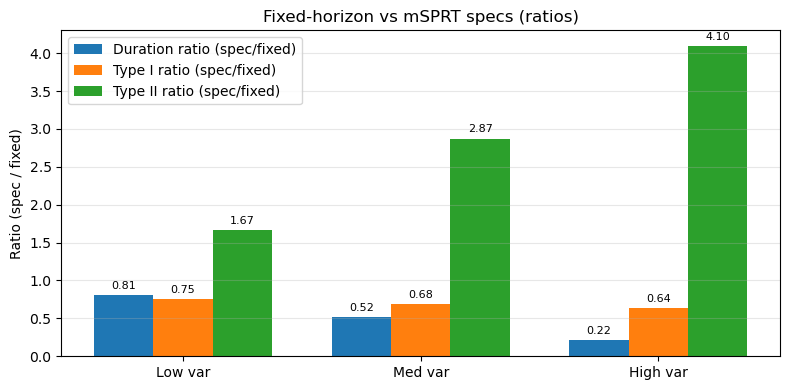

In [57]:
# Bar chart comparing fixed vs three mSPRT specs (new cell 23)

specs = ['msprt_low_var', 'msprt_med_var', 'msprt_high_var']
labels = ['Low var', 'Med var', 'High var']

fixed_avg_duration = summary_alt['fixed']['avg_duration']
fixed_typeII = summary_alt['fixed']['type_II_error']
fixed_typeI = alpha  # use nominal alpha for fixed-horizon Type I

spec_avg_durations = np.array([summary_alt[s]['avg_duration'] for s in specs], dtype=float)
spec_typeII = np.array([summary_alt[s].get('type_II_error', np.nan) for s in specs], dtype=float)
spec_typeI = np.array([summary_null[s].get('type_I_error', np.nan) for s in specs], dtype=float)

# compute ratios (spec / fixed), guard against division by zero / nan
duration_ratio = spec_avg_durations / fixed_avg_duration
typeI_ratio = np.where(np.isfinite(spec_typeI) & (spec_typeI != 0), spec_typeI / fixed_typeI, np.nan)
typeII_ratio = np.where(np.isfinite(spec_typeII) & (spec_typeII != 0), spec_typeII / fixed_typeII, np.nan)

x = np.arange(len(specs))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x - width, duration_ratio, width, label='Duration ratio (spec/fixed)', color='C0')
ax.bar(x, typeI_ratio, width, label='Type I ratio (spec/fixed)', color='C1')
ax.bar(x + width, typeII_ratio, width, label='Type II ratio (spec/fixed)', color='C2')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Ratio (spec / fixed)')
ax.set_title('Fixed-horizon vs mSPRT specs (ratios)')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# annotate bars with numeric values
for bars in ax.containers:
    for bar in bars:
        h = bar.get_height()
        if np.isfinite(h):
            ax.annotate(f'{h:.2f}', xy=(bar.get_x() + bar.get_width() / 2, h),
                        xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### Plot distribution of durations

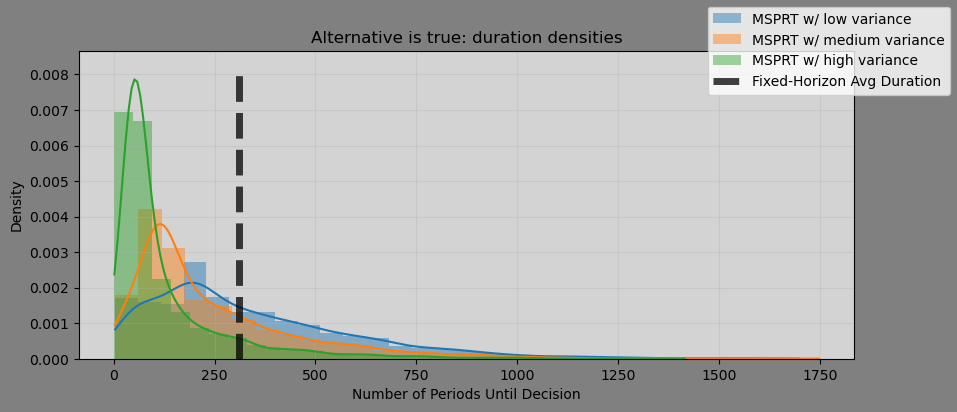

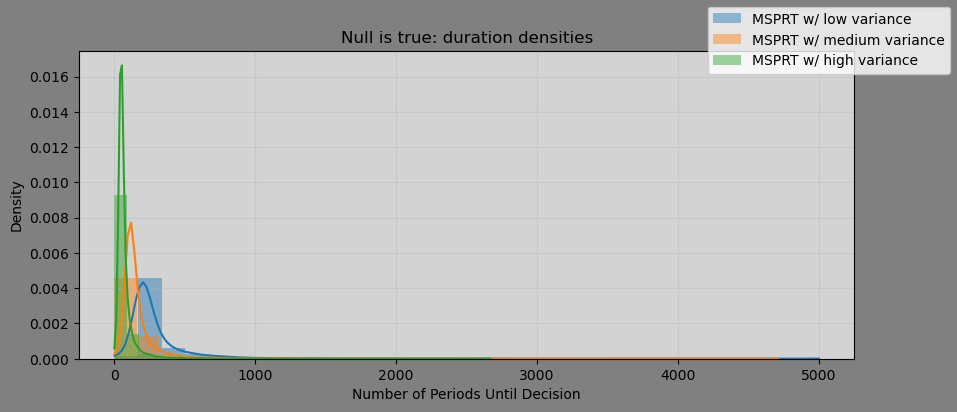

(<Figure size 1000x400 with 1 Axes>,
 <Axes: title={'center': 'Null is true: duration densities'}, xlabel='Number of Periods Until Decision', ylabel='Density'>)

In [38]:

# plot densities for alternative
plot_duration_densities(
    results_alt,
    title='Alternative is true: duration densities',
    fixed_avg_duration=summary_alt.get('fixed', {}).get('avg_duration', None)
)

# plot densities for null
plot_duration_densities(
    results_null,
    title='Null is true: duration densities'
)


In [ ]:
break

# Appendix Code
* mSPRT functions for discrete priors
* Simulation functions discrete priors
* Plot error over duration

In [ ]:
def mixture_sprt(true_mu, prior_mus, prior_weights):
    A = (1 - beta) / alpha
    B = beta / (1 - alpha)
    logA, logB = np.log(A), np.log(B)

    log_lr = 0.0

    for t in range(1, max_periods + 1):
        x = generate_period(true_mu, sigma, n_per_period)

        ll0 = np.sum(norm.logpdf(x, 0, sigma))

        lls = [np.log(w) + np.sum(norm.logpdf(x, mu, sigma))
               for w, mu in zip(prior_weights, prior_mus)]
        ll1 = np.logaddexp.reduce(lls)

        log_lr += ll1 - ll0

        if log_lr >= logA:
            return t, 1  # reject H0
        if log_lr <= logB:
            return t, 0  # accept H0

    return max_periods, int(log_lr > 0)

In [ ]:
print('discrete prior MSPRT simulations')
## Create a function that assigns weights based on the length of the priors. This is
## basically like a triangle distribution.
def triangular_prior_weights(n):
    n = int(n)
    if n <= 0:
        return np.array([])
    if n % 2 == 1:
        k = n // 2
        left = np.arange(1, k + 2)
        weights = np.concatenate([left, left[:-1][::-1]]).astype(float)
    else:
        k = n // 2
        left = np.arange(1, k + 1)
        weights = np.concatenate([left, left[::-1]]).astype(float)
    return weights / weights.sum()  

## Priors for MSPRT
# Low-variance prior (well-specified)
prior_Alow_mu = np.array([0.95, 1.0, 1.05]) * true_mu
prior_Alow_w = triangular_prior_weights(len(prior_Alow_mu))

# High-variance prior (diffuse)
prior_Ahigh_mu = np.array([0.2, 0.8, 0.9, 1.0, 1.1, 1.2, 1.8]) * true_mu
prior_Ahigh_w = triangular_prior_weights(len(prior_Ahigh_mu))

## Priors are centered on the wronge value
# Low-variance prior (well-specified)
prior_Blow_mu = prior_Alow_mu + true_mu
prior_Blow_w = triangular_prior_weights(len(prior_Blow_mu))

# High-variance prior (diffuse)
prior_Bhigh_mu = prior_Ahigh_mu + true_mu
prior_Bhigh_w = triangular_prior_weights(len(prior_Bhigh_mu))


In [ ]:
def run_simulations_discrete(n_sim, mu, prior_specs, prior_names):
    results = {'fixed': []}
    for prior_name in prior_names:
        results[prior_name] = []

    for _ in range(n_sim):
        if mu != 0:
            results['fixed'].append(fixed_horizon_test(mu))
        else:
            pass
        for i, (prior_mu, prior_w) in enumerate(prior_specs):
            results[prior_names[i]].append(
                mixture_sprt(mu, prior_mu, prior_w)
            )
        
    return results

# Under the alternative
results_alt = run_simulations_discrete(n_sim=N_SIM, mu=true_mu
                            , prior_specs=[(prior_Alow_mu, prior_Alow_w), (prior_Ahigh_mu, prior_Ahigh_w), 
                                            (prior_Blow_mu, prior_Blow_w), (prior_Bhigh_mu, prior_Bhigh_w) ]
                            , prior_names=['msprt_low', 'msprt_high', 'msprt_low_mis', 'msprt_high_mis'])
summary_alt = {k: summarize(results_alt[k], is_null=False) for k in results_alt}
for k in summary_alt.keys():
    print(f"{k}:", summary_alt[k])


# Under the null. Note that the fixed-horizon test is not run here.
results_null = run_simulations_discrete(n_sim=N_SIM, mu=0
                            , prior_specs=[(prior_Alow_mu, prior_Alow_w), (prior_Ahigh_mu, prior_Ahigh_w), 
                                            (prior_Blow_mu, prior_Blow_w), (prior_Bhigh_mu, prior_Bhigh_w) ]
                            , prior_names=['msprt_low', 'msprt_high', 'msprt_low_mis', 'msprt_high_mis'])
summary_null = {k: summarize(results_null[k], is_null=True) for k in results_null}
for k in summary_null.keys():
    print(f"{k}:", summary_null[k])

In [ ]:
def plot_error_vs_duration(results_input):
    fig, ax = plt.subplots(figsize=(8, 3), facecolor='lightgrey')

    for x in [p for p in results_input.keys() if p !='fixed']:      
        durations = np.array([r[0] for r in results_input[x]])
        decisions = np.array([r[1] for r in results_input[x]])  # 1 = reject H0 (power), 0 = fail to reject

        edges = np.percentile(durations, np.arange(0, 101, 10))  # decile edges
        bins = np.digitize(durations, edges, right=True)

        bin_centers = []
        avg_error = []  # under ALT, error = Type II = 1 - decision
        for i in range(1, len(edges)):
            mask = bins == i
            if mask.sum() == 0:
                continue
            bin_centers.append(durations[mask].mean())
            avg_error.append(1.0 - decisions[mask].mean())
        ax.plot(bin_centers, avg_error, marker='o', linestyle='-', label=x)

    ax.set_xlabel('Average number of periods (decile)')
    ax.set_ylabel('Average Type II error (1 - power)')
    ax.set_title('MSPRT1 average error rate over duration deciles')
    ax.legend()
    # ax.set_ylim(0, 1)
    ax.grid(alpha=0.3)
    ax.set_facecolor('grey')
    plt.show()
    

In [ ]:
plot_error_vs_duration(results_alt)
plot_error_vs_duration(results_null)